# Unfolding of an Experimental 16 MeV on Be PHS

This notebook contains the specific commands used to take the 16 MeV on Be experimental data from Root TTrees and turn them into the correctly formatted .phs and .rsp files for the the NSD and HEPROW unfolding programs.  It will also generate the input neutron spectrum to use in comparison.  

This notebook is broken into the following sections: <br\>
1) Calibration of PHS <br\>
2) Response Matrix Generation <br\>
3) HEPROW Unfold <br\>
4) NSD Unfold <br\>
5) Results <br\>

Root must be installed and PyRoot enabled for this notebook to work.

First, load the necessary libraries, set the appropriate environment variables, and compile the C++ support macros from the instructions @ https://bitbucket.org/berkeleylab/nsd-rootscripts/wiki/LibraryCompilation.

Load python dependencies:

In [1]:
from ROOT import gROOT
import numpy as np

gROOT.ProcessLine('HistogramWriter writer;')
gROOT.ProcessLine('HistogramOperations ops;')

47826801377328L

## PHS Calibration

The calibration was done elsewhere by Matthew Harasty.  The calibration parameters found were:

parameters = {S,kb, 0.00317023,-0.396197,0.0972016,8.67104e-05,0.0193443} <br\>
covMat = {8.74484e-08, -1.75375e-05, 3.88910e-06, 1.17423e-11, 3.33287e-07, <br\>
         -1.75375e-05, 0.00669927, 0.000170623, 1.01985e-09, 4.67549e-05, <br\>
          3.88910e-06, 0.000170623, 0.0375140, -1.98734e-08, -0.000428478, <br\>
          1.17423e-11, 1.01985e-09, -1.98734e-08, 2.83232e-06, -1.46480e-09, <br\>
          3.33287e-07, 4.67549e-05, -0.000428478, -1.46480e-09, 0.00329089} <br\>

### User inputs

dataPath = the absolute location of where the root files are located <br/>
phsName = file name for the pulse height spectra TTree <br/>
outPath = the absolute path of where to place the generated HEPROW input files

In [2]:
dataPath="/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Data/"
phsName="Experiments/PHS/16MeVBe/SinglePh.root"
outPath="/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Data/Experiments/PHS/16MeVBe/Unfold/HEPROW/Inputs/"

### Load PHS Data File

In [3]:
gROOT.ProcessLine('TFile f("{}")'.format(dataPath+phsName))

47826801377376L

### Apply Calibration and print the .phs file

The calibration constants used were:  

a = 0.00317023 <br/>
b = -0.396197 <br/>
Ec = 0.0972016  <br/>
E1 = 8.67104e-05 <br/>
E2 = 0.0193443 <br/> 

In [4]:
gROOT.ProcessLine('ops.applyCalibration(histo3, 0.00317023,-0.396197);')

0L

In [5]:
gROOT.ProcessLine('histo3->Draw()')

0L

Truncate all negative and all zeros data.  This is necessary for unfolding in HEPROW.

Find the first bin with data.  The cell will print the first bin, but not the lower MeVee edge.  It is a bit clunky, but you can read it directly from the terminal running this notebook (or run the commands in Root directly).

In [6]:
gROOT.ProcessLine('tmpSpectrum = (TH1D*)ops.truncateHist(histo3,0.105,14);')

i=0
while gROOT.ProcessLine('tmpSpectrum->GetBinContent({})'.format(i))==0:
    i+=1
print i

gROOT.ProcessLine('tmpSpectrum->GetXaxis()->GetBinLowEdge({})'.format(i))

68


0L

Choose a rebin number to get the desired MeVee/bin.  In this case, 4 was chosen to get ~ 0.01 MeVee/bin 

In [7]:
rebin=4
gROOT.ProcessLine('PulseHeightSpectrum = (TH1D*)ops.truncateHist(tmpSpectrum,3.172e-01,14);')
gROOT.ProcessLine('PulseHeightSpectrum->Rebin({})'.format(rebin))
gROOT.ProcessLine('PulseHeightSpectrum->GetXaxis()->GetBinLowEdge({})'.format(0))
gROOT.ProcessLine('PulseHeightSpectrum->Draw()')

TH1D::Rebin:0: RuntimeWarning: ngroup=4 is not an exact divider of nbins=3873.


0L

Print out the .phs file for both statistic bins and the intrinsic rebin from above:

In [8]:
gROOT.ProcessLine('TH1* dataHist = ops.rebinStatistically(PulseHeightSpectrum,100);')
gROOT.ProcessLine('writer.PhToHEPROW(PulseHeightSpectrum,"{}histo3_phs_01")'.format(outPath))
gROOT.ProcessLine('writer.PhToHEPROW(dataHist,"{}histo3_stat_100_phs_01")'.format(outPath))

0L

## Response Matrix

### Response Matrix Inputs

rspName = file name for the response matrix TTree <br/>

rspEwidth = the width of bins to use for the binning of the response matrix energy <br/>
rspEmin = the minimum Energy to use for the binning of the response matrix  <br/>
rspEmax = the maximum Energy to use for the binning of the response matrix  <br/>
rspLwidth = the width of bins to use for the binning of the response matrix light <br/>
rspLmin = the minimum Light to use for the binning of the response matrix  <br/>
rspLmax = the maximum Light to use for the binning of the response matrix  <br/>

In [10]:
rspName="Simulated/PHS/ResponseMatrices/simSideResponse20Mil.root"

rspEwidth=1
rspEmin=0.0
rspEmax=25.0
rspLwidth=0.01
rspLmin=0.0
rspLmax=16.0

### Load Response Matrix Data File

In [11]:
gROOT.ProcessLine('SimulationManipulation sm("{}",0)'.format(dataPath+rspName))

0L

### Create the bin structures and print .rsp file

In [12]:
# Create the bin structures
rspEbins=np.arange(rspEmin,rspEmax,rspEwidth)
rspEbins=np.append(rspEbins,rspEmax)
#print rspEbins
rspLbins=np.arange(rspLmin,rspLmax,rspLwidth)
rspLbins=np.append(rspLbins,rspLmax)
#print rspLbins
gROOT.ProcessLine('const Int_t EBINS = {}; const Int_t LBINS = {};'.format(len(rspEbins)-1,len(rspLbins)-1))
gROOT.ProcessLine('Double_t eEdges[EBINS + 1] = {}{}{};'.format("{",", ".join(str(e) for e in rspEbins),"}"))
gROOT.ProcessLine('Double_t lEdges[LBINS + 1] = {}{}{};'.format("{",", ".join(str(e) for e in rspLbins),"}"))
gROOT.ProcessLine('axis1 = TAxis(EBINS,eEdges);')
gROOT.ProcessLine('axis2 = TAxis(LBINS,lEdges);')

# Create the Histogram and output file
gROOT.ProcessLine('TH2* hist=sm.getNormalizedResponseMatrix(axis1,axis2)')
gROOT.ProcessLine('hist->Draw("colz")')
gROOT.ProcessLine('writer.ResponseToHEPROW(hist,"{}resp_01_1")'.format(outPath))

0L

### Smear the Response Matrix and Create the .rsp File

In [13]:
gROOT.ProcessLine('TH2* smearHist2 = ops.skewedGausSmearMatrix(hist,0.0972016,8.67104e-05,0.0193443)')
gROOT.ProcessLine('smearHist2->Draw("colz")')
gROOT.ProcessLine('writer.ResponseToHEPROW(smearHist2,"{}smearedResp_01_1")'.format(outPath))

0L

## HEPROW Unfold

The actually running of HEPROW is done separately through the Windows executables.  The location for the files is: <br\>

/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Data/Experiments/PHS/16MeVBe/Unfold/HEPROW

### Mik.inp Support

These lines are useful to develop the mik.inp file:

In [14]:
bounds = np.linspace(2.0,rspEmax-1,len(rspEbins)-3)   #(First right bin boundary, last right bin, boundary, number of bins)
print len(bounds)
for i in range(0,len(bounds)):
    print '{}                                      right boundary of energy interval {}'.format(bounds[i],i+1)

23
2.0                                      right boundary of energy interval 1
3.0                                      right boundary of energy interval 2
4.0                                      right boundary of energy interval 3
5.0                                      right boundary of energy interval 4
6.0                                      right boundary of energy interval 5
7.0                                      right boundary of energy interval 6
8.0                                      right boundary of energy interval 7
9.0                                      right boundary of energy interval 8
10.0                                      right boundary of energy interval 9
11.0                                      right boundary of energy interval 10
12.0                                      right boundary of energy interval 11
13.0                                      right boundary of energy interval 12
14.0                                      right boundary of energy

## NSD Unfold

This uses the unfolding algorithms developed by Matt Harasty and Josh Brown contained in the nsd-rootscripts library to unfold the same data.  

First we must load the script to do the unfolding. NOTE: All of the parameters set in this notebook above are done explicitly within this script.  It is recommended that a unique script be made in each unfold directory to document the settings used.

NOTE: Do not run the ROOT import cell if it was run about and still active in the kernel.  It is repeated here for convience when not doing the HEPROW processing.

In [15]:
from ROOT import gROOT

gROOT.ProcessLine('HistogramWriter writer;')

0L

In [16]:
gROOT.ProcessLine('.L /home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Unfolding/Experiments/16MeVBe/Unfold/16MeVBeUnfold.cpp')

0L

### Run the Algorithm

Create the unfolding object, run the unfolding algorithm, and plot the results:

In [17]:
gROOT.ProcessLine('NeutronSpectrumUnfolding* obj = setup1MeVUnfolding()')
gROOT.ProcessLine('obj->runRootMinimization("Minuit")')
gROOT.ProcessLine('obj->drawState()')

0L

### Write the results 

Save to both a root file and .phs file:

In [18]:
gROOT.ProcessLine('obj->writeState("/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Unfolding/Experiments/16MeVBe/Unfold/NSDUnfolded16MeV_Cal3_1.root")')
gROOT.ProcessLine('TH1D* outputHisto = obj->getCurrentTrialClone()')
gROOT.ProcessLine('writer.Th1ToAscii(outputHisto, "/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Unfolding/Experiments/16MeVBe/Unfold/NSD16MeVSpectrum_Cal3_1")')

0L

In [19]:
#Unfolding with error process
In the compile directory for nsd-rootscripts:
1) Modify RunMCUnfoldError.cpp to have the correct variables.   
2) make RunMCUnfoldError.exe
3) ./RunMCUnfoldError.exe

SyntaxError: invalid syntax (<ipython-input-19-af652812e6a5>, line 2)

## Results

This section contains all of the output post-processing to end up with a plot of the spectrum.

In [1]:
import sys
import os

import pandas as pd
import numpy as np

from datetime import datetime

%matplotlib inline

# Path to support scripts 
sys.path.insert(0,os.path.abspath('/home/pyne-user/Dropbox/UCB/Computational_Tools/Scripts/Python/DataAnalysis'))
from DataManipulation import bin_differentiation, normAUBC
from DataIO import read_delimited_data_file
from Histograms import Histogram

sys.path.insert(0,os.path.abspath('/home/pyne-user/Dropbox/UCB/Computational_Tools/Scripts/Python/Unfolding'))
from HEPROW import readMTX, readGru, readFlu
from Root import FluxNormalization

sys.path.insert(0,os.path.abspath('/home/pyne-user/Dropbox/UCB/Computational_Tools/Scripts/Python/GeneralNuclear'))
from Detectors import nonparalyzable_beam_dead_time, nonparalyzable_dead_time

### Set normalization parameters

Based on the detector setup and readings from the current integrator and current monitor reported earlier in this notbook.

In [2]:
norm = FluxNormalization()
norm.runTime=48*60.+48
norm.currentMonitor = 0.99E-3*norm.runTime
norm.currentIntegrator = 0.66E-3*norm.runTime
norm.set_solid_angle(640+36.3, 25)
norm.set_dead_time(nonparalyzable_beam_dead_time, obsCountRate=(1285960)/norm.runTime, 
                   tauDetector=1.25E-6, tauBeam=158E-9)
print str(norm)


Normalization Parameters
Total Run Time = 2928.0 s
Current Monitor Inegrated Current = 2.89872 microC
Current Integrator Reading = 1.93248 microC
Solid Angle = 5.46589436057e-05 sr
Fractional Dead Time = 0.0



### Set Data Locations

In [3]:
# HEPROW Inputs:
heprowPath = "/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Data/Experiments/PHS/16MeVBe/Unfold/HEPROW/"

heprowName = "mik_1.gru"
unfanaName = "unf_1.gru"
gravelName = "grv_out_1.flu"
faltwPHSName = "faltw_1.phs"
measPHSName = "Inputs/histo3_stat_100_phs_01.phs"
mtxName = "MIEKE_1.MTX"
heprowBinBounds = "low"

# Meulders - 16 MeV d on Be 
meuldersPath="/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Data/Experiments/PHS/16MeVBe/Unfold/"

meuldersName="Meulders_1.txt"
meuldersBinBounds="mid"

# Lone
lonePath="/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Data/Experiments/PHS/16MeVBe/Unfold/"

loneName="Lone_1.txt"
loneBinBounds="low"

# Output
outPath="/home/pyne-user/Dropbox/UCB/Research/ETAs/88Inch/Data/Experiments/PHS/16MeVBe/Unfold/"

### Read in and Manipulate Data

Convert Each Data Set to a Probability Density Function (PDF), calculate error for PDF, and normalize the abs spectrum.

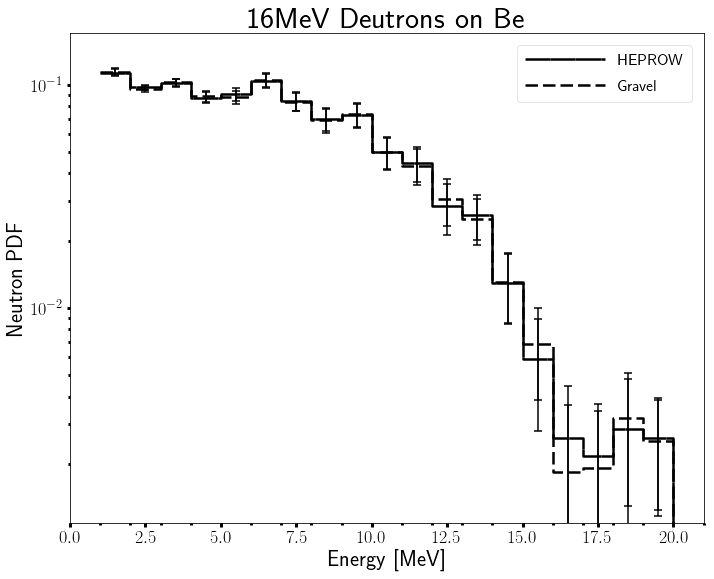

In [4]:
# Import HEPROW, UNFANA, and Gravel data and normalize
heprowData = readGru(heprowPath+heprowName, delim_whitespace=True, names=['lowE', 'absFlux', 'absSigma'],
               skiprows=3)
heprowData['normFlux'] = np.asarray(bin_differentiation(heprowData['lowE'].tolist(), 
                                            heprowData['absFlux'].tolist(), heprowBinBounds)) \
                                            / norm.currentIntegrator / norm.solidAngle \
                                            / (1-norm.deadTime)
heprowData['normSigma'] = np.asarray(bin_differentiation(heprowData['lowE'].tolist(), 
                                            heprowData['absSigma'].tolist(), heprowBinBounds)) \
                                            / norm.currentIntegrator / norm.solidAngle \
                                            / (1-norm.deadTime)
        
unfData = readGru(heprowPath+unfanaName, delim_whitespace=True, names=['lowE', 'absFlux', 'absSigma'],
               skiprows=3)
unfData['normFlux'] = np.asarray(bin_differentiation(unfData['lowE'].tolist(), 
                                            unfData['absFlux'].tolist(), heprowBinBounds)) \
                                            / norm.currentIntegrator / norm.solidAngle \
                                            / (1-norm.deadTime)
unfData['normSigma'] = np.asarray(bin_differentiation(unfData['lowE'].tolist(), 
                                            unfData['absSigma'].tolist(), heprowBinBounds)) \
                                            / norm.currentIntegrator / norm.solidAngle \
                                            / (1-norm.deadTime)    
        
grvData = readFlu(heprowPath+gravelName, delim_whitespace=True, names=['lowE', 'absFlux', 'absSigma'],
               skiprows=3)
grvData['normFlux'] = np.asarray(bin_differentiation(grvData['lowE'].tolist(), 
                                            grvData['absFlux'].tolist(), heprowBinBounds)) \
                                            / norm.currentIntegrator / norm.solidAngle \
                                            / (1-norm.deadTime)
grvData['normSigma'] = np.asarray(bin_differentiation(grvData['lowE'].tolist(), 
                                            grvData['absSigma'].tolist(), heprowBinBounds)) \
                                            / norm.currentIntegrator / norm.solidAngle \
                                            / (1-norm.deadTime)      
        
# Calculate covariance based uncertainty
heprowData['absCovSigma'] = readMTX(heprowPath+mtxName).tolist()
unfData['absCovSigma'] = readMTX(heprowPath+mtxName).tolist()
grvData['absCovSigma'] = readMTX(heprowPath+mtxName).tolist()

# Calculate the pdf and its uncertainty
heprowData['pdfFlux'] = normAUBC(heprowData['absFlux'])
heprowData['pdfSigma'] = heprowData['absSigma']/heprowData['absFlux']*heprowData['pdfFlux']
heprowData['pdfCovSigma'] = heprowData['absCovSigma']/heprowData['absFlux']*heprowData['pdfFlux']

unfData['pdfFlux'] = normAUBC(unfData['absFlux'])
unfData['pdfSigma'] = unfData['absSigma']/unfData['absFlux']*unfData['pdfFlux']
unfData['pdfCovSigma'] = unfData['absCovSigma']/unfData['absFlux']*unfData['pdfFlux']

grvData['pdfFlux'] = normAUBC(grvData['absFlux'])
grvData['pdfSigma'] = grvData['absSigma']/grvData['absFlux']*grvData['pdfFlux']
grvData['pdfCovSigma'] = grvData['absCovSigma']/grvData['absFlux']*grvData['pdfFlux']

# Build pdf histogram object
heprowHisto = Histogram()
heprowHisto.build_histo(heprowData['lowE'].tolist(), heprowData['pdfFlux'].tolist(),
                       uncert=heprowData['pdfCovSigma'].tolist(), edgeLoc=heprowBinBounds,
                       name='HEPROW')
unfHisto = Histogram()
unfHisto.build_histo(unfData['lowE'].tolist(), unfData['pdfFlux'].tolist(),
                       uncert=unfData['pdfCovSigma'].tolist(), edgeLoc=heprowBinBounds,
                       name='UNFANA')
grvHisto = Histogram()
grvHisto.build_histo(grvData['lowE'].tolist(), grvData['pdfFlux'].tolist(),
                       uncert=grvData['pdfCovSigma'].tolist(), edgeLoc=heprowBinBounds,
                       name='Gravel')
heprowHisto.plot(grvHisto,logY=True, title='16MeV Deutrons on Be', xLabel='Energy [MeV]',
                 yLabel='Neutron PDF')
heprowHisto.write(outPath+'HEPROW_1_pdf', includeUncert=True, edge=False)

# Build norm histogram object
heprowNormHisto = Histogram()
heprowNormHisto.build_histo(heprowData['lowE'].tolist(), heprowData['normFlux'].tolist(),
                       uncert=heprowData['normSigma'].tolist(), edgeLoc=heprowBinBounds,
                       name='HEPROW')
heprowNormHisto.write(outPath+'HEPROW_1_norm', includeUncert=True, edge=False)

# Build error histogram objects
heprowErrorHisto = Histogram()
heprowErrorHisto.build_histo(heprowData['lowE'].tolist(),
                               heprowData['pdfSigma']/heprowData['pdfFlux'].tolist(),
                               edgeLoc=heprowBinBounds, name='HEPROW Errors')
heprowCovErrorHisto = Histogram()
heprowCovErrorHisto.build_histo(heprowData['lowE'].tolist(),
                               heprowData['pdfCovSigma']/heprowData['pdfFlux'].tolist(),
                               edgeLoc=heprowBinBounds, name='HEPROW Covariance Errors')

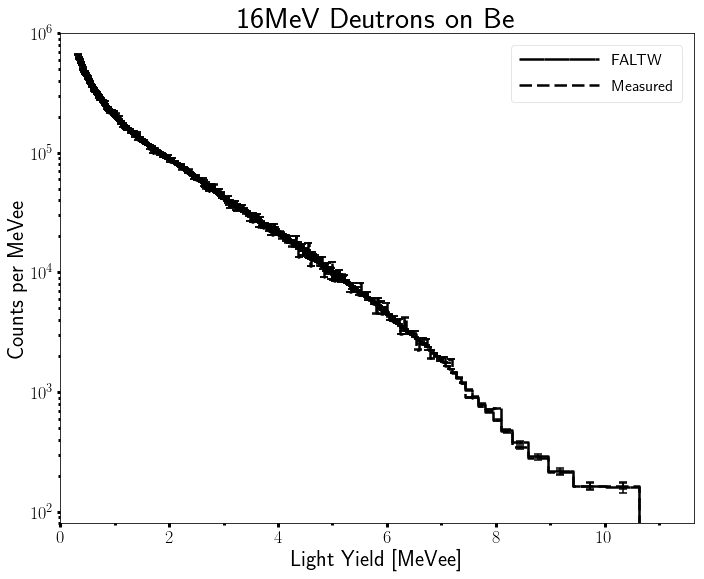

In [33]:
# Import PHS data and plot
faltwPHSData = readFlu(heprowPath+faltwPHSName, delim_whitespace=True, names=['lowE', 'absPHS', 'absSigma'],
               skiprows=3)
measPHSData = readFlu(heprowPath+measPHSName, delim_whitespace=True, names=['lowE', 'absPHS', 'absSigma'],
               skiprows=3)
faltwPHSHisto = Histogram()
faltwPHSHisto.build_histo(faltwPHSData['lowE'].tolist(), 
                         bin_differentiation(faltwPHSData['lowE'].tolist(),
                                             faltwPHSData['absPHS'].tolist()),
                       uncert=faltwPHSData['absSigma'].tolist(), edgeLoc=heprowBinBounds,
                       name='FALTW')
measPHSHisto = Histogram()
measPHSHisto.build_histo(measPHSData['lowE'].tolist(), 
                         bin_differentiation(measPHSData['lowE'].tolist(),
                                             measPHSData['absPHS'].tolist()),
                         uncert=measPHSData['absSigma'].tolist(), edgeLoc=heprowBinBounds,
                         name='Measured')
faltwPHSHisto.plot(measPHSHisto, logY=True, title='16MeV Deutrons on Be', xLabel='Light Yield [MeVee]',
                 yLabel='Counts per MeVee')

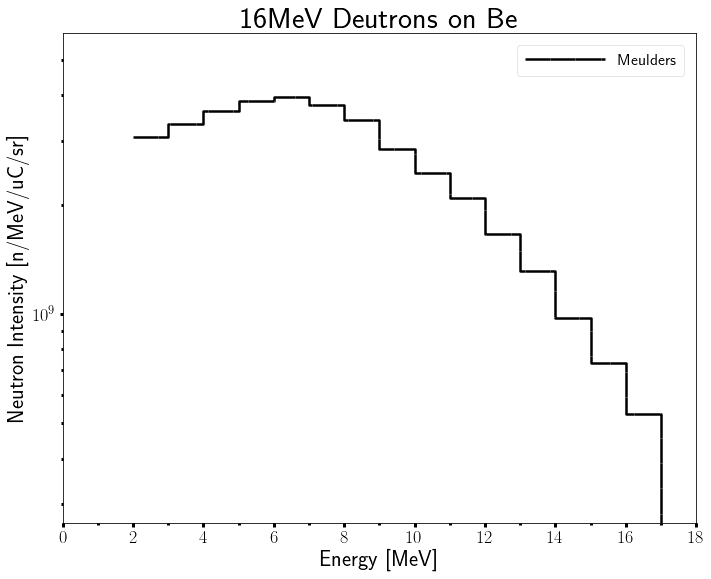

In [34]:
# Read in Meulders data and normalize
meuldersData = pd.read_table(meuldersPath+meuldersName, delim_whitespace=True, 
                             names=['midE', 'absFlux'])
meuldersData['absFlux'] = bin_differentiation(meuldersData['midE'],meuldersData['absFlux'],
                                             edgeLoc="mid")
meuldersData['pdfFlux'] = normAUBC(meuldersData['absFlux'])

# Build pdf histogram object
meuldersHisto=Histogram()
meuldersHisto.build_histo(meuldersData['midE'].tolist(), meuldersData['pdfFlux'].tolist(), 
                         edgeLoc=meuldersBinBounds, name='Meulders')

# Build norm histogram object
meuldersNormHisto=Histogram()
meuldersNormHisto.build_histo(meuldersData['midE'].tolist(), meuldersData['absFlux'].tolist(), 
                         edgeLoc=meuldersBinBounds, name='Meulders')
meuldersNormHisto.plot(logY=True, title='16MeV Deutrons on Be', xLabel='Energy [MeV]',
                 yLabel='Neutron Intensity [n/MeV/uC/sr]')

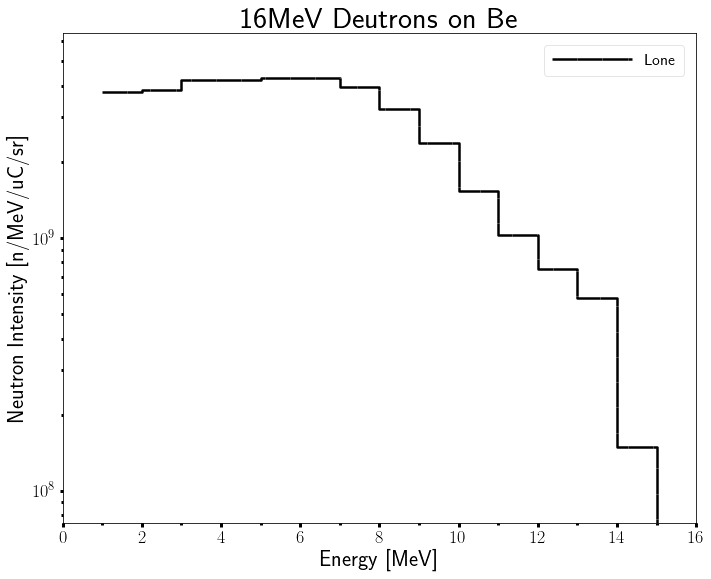

In [35]:
# Read in Lone data and normalize
loneData = pd.read_table(lonePath+loneName, delim_whitespace=True, 
                             names=['midE', 'absFlux'])
loneData['absFlux'] = bin_differentiation(loneData['midE'],loneData['absFlux'],
                                             edgeLoc="mid")
loneData['pdfFlux'] = normAUBC(loneData['absFlux'])

# Build pdf histogram object
loneHisto=Histogram()
loneHisto.build_histo(loneData['midE'].tolist(), loneData['pdfFlux'].tolist(), 
                         edgeLoc=loneBinBounds, name='Lone')

# Build norm histogram object
loneNormHisto=Histogram()
loneNormHisto.build_histo(loneData['midE'].tolist(), loneData['absFlux'].tolist(), 
                         edgeLoc=loneBinBounds, name='Lone')
loneNormHisto.plot(logY=True, title='16MeV Deutrons on Be', xLabel='Energy [MeV]',
                 yLabel='Neutron Intensity [n/MeV/uC/sr]')

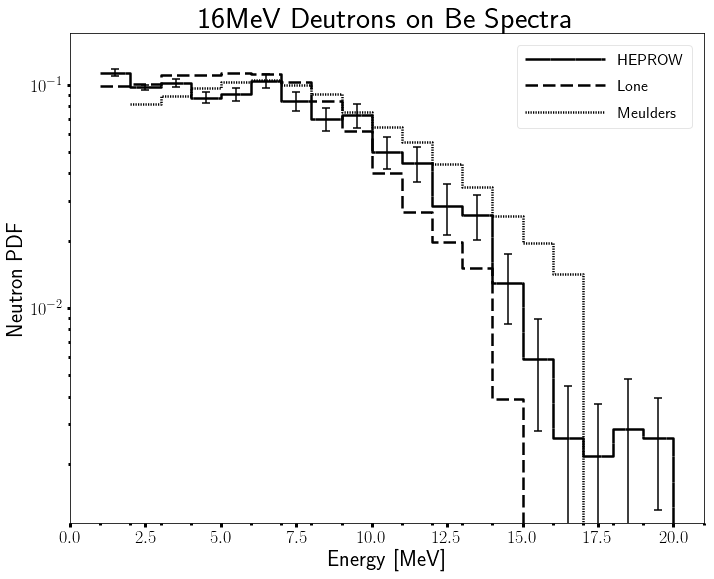

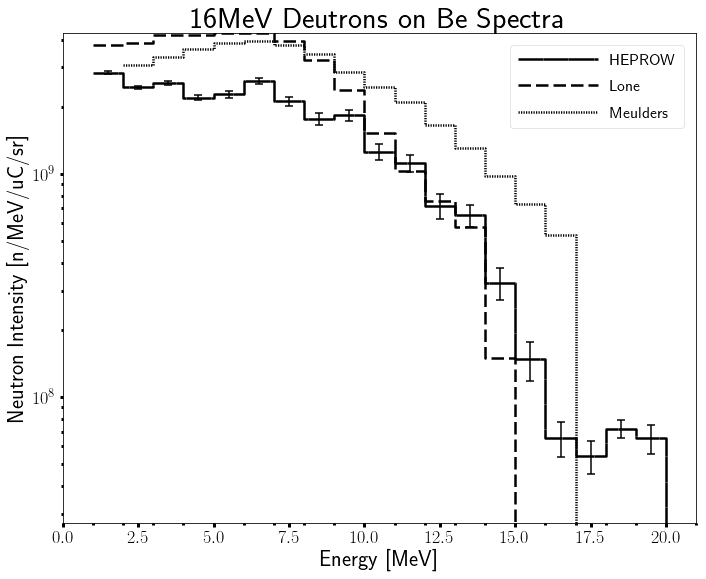

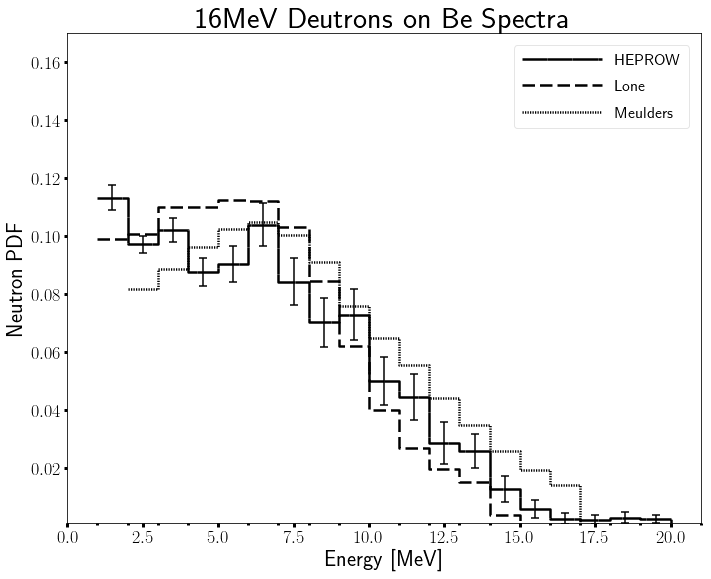

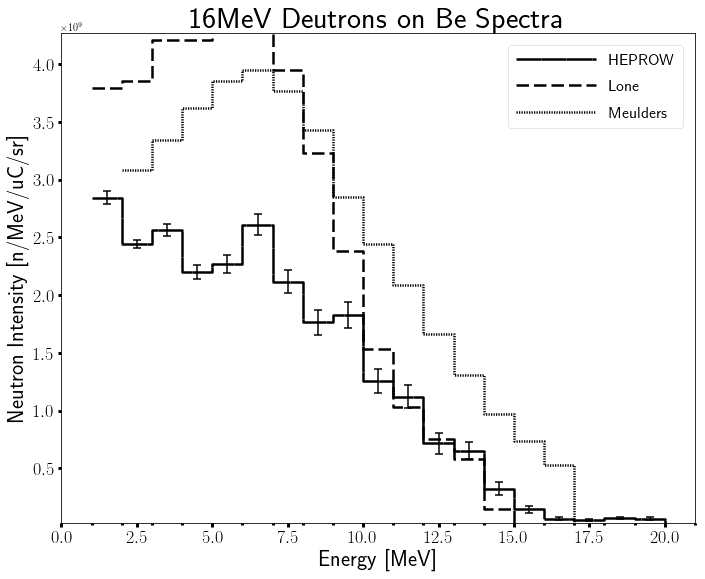

In [36]:
# Log
heprowHisto.plot(loneHisto, meuldersHisto, logY=True, title='16MeV Deutrons on Be Spectra',
                 xLabel='Energy [MeV]', yLabel='Neutron PDF',
                 savePath=outPath+'16MeVBe_all_pdf_log_1')
heprowNormHisto.plot(loneNormHisto, meuldersNormHisto, logY=True, title='16MeV Deutrons on Be Spectra',
                     xLabel='Energy [MeV]', yLabel='Neutron Intensity [n/MeV/uC/sr]',
                     savePath=outPath+'16MeVBe_all_norm_log_1')
#heprowCovErrorHisto.plot(heprowErrorHisto, nsdErrorHisto, logY=True, 
#                         title='16MeV Deutrons on Ta Spectra Errors',
#                         xLabel='Energy [MeV]', yLabel='Relative Error')

# Linear
heprowHisto.plot(loneHisto, meuldersHisto, title='16MeV Deutrons on Be Spectra',
                 xLabel='Energy [MeV]', yLabel='Neutron PDF')
heprowNormHisto.plot(loneNormHisto, meuldersNormHisto, title='16MeV Deutrons on Be Spectra',
                 xLabel='Energy [MeV]', yLabel='Neutron Intensity [n/MeV/uC/sr]')